# Setting up for analysis of TIGRESS simulation vtk output

# packages to be used
 * matplotlib http://matplotlib.org/
 * numpy http://www.numpy.org/
 * pandas http://pandas.pydata.org/
 * astropy http://www.astropy.org/

### First need to import standard python packages: 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
import sys
sys.path.insert(0,'../')
from matplotlib.colors import LogNorm

In [2]:
import os

### To read and extract information from TIGRESS data we use modules from the pyathena package

In [3]:
import pyathena as pa
pa.__file__

'../pyathena/__init__.py'

## Unit system

The unit system for the TIGRESS simulations is
* [length] = pc
* [velocity] = km/s
* [density] = 1.4271*m_H/cm^3

In [4]:
#We use set_units from pyathena for units conversions
# This uses units and constants from astropy
from pyathena import set_units
set_units

<function pyathena.set_units.set_units>

In [5]:
unit=pa.set_units(muH=1.4271)
print unit['density'].cgs/1.4271/c.m_p.cgs
print unit['velocity']
print unit['length']
print unit['mass']
print unit['time']
print unit['magnetic_field']

1.0 1 / cm3
1.0 km / s
1.0 pc
0.0352682242985 solMass
0.977792221673 Myr
0.547685223955 uG


In [6]:
# other units can be easily obtained
print unit.keys()

['number_density', 'temperature', 'density', 'magnetic_field', 'pressure', 'length', 'mass', 'time', 'velocity', 'muH', 'gravitational_potential']


In [7]:
#These are useful for conversions 
codemass=unit['mass']
codetime=unit['time']
codelength=unit['length']
codevel=unit['velocity']
print codemass,codetime,codelength,codevel

0.0352682242985 solMass 0.977792221673 Myr 1.0 pc 1.0 km / s


## Read full data cube of MHD variables 

The original data from TIGRESS simulations is written as "vtk" files. Each vtk file has data for all physical field variables (density, velocity, etc) in each cell for a part of the simulation "domain." In Athena, each sub-domain is called a "grid".  For MPI simulations, at each timestep when there is a vtk dump, Athena writes a separate vtk file from each proccessor. All the vtk files from a given processor (i.e. all time snapshots for data from a given "grid") are written to a directory for just that processor: /id0, /id1, /id2, etc.   

Here we will use the pyathena reader to open the separate vtk files from a given time, get data from each grid, and merge into a big data array for the full domain.

## The vtk file directory must be set up 

#### You may be using either simulations that have already been run (1), or new simulations (2)

### (1) Data Location for TIGRESS solar nbhd. simulations that have already been run:

* "4pc" model output can be found in directories `basedir/MHD_4pc_new/` and `basedir/R8_4pc_newacc/`

* "2pc" model (based on restart of 4pc model) output can be found in `basdir/MHD_2pc_new` and `basedir/R8_2pc_rst/`

* There are also "8pc" and "16pc" lower-resolution data in `basedir`


####  For description of the various Solar neighborhood simulations (box size, feedback type, restart time, etc.) see:
* https://github.com/PrincetonUniversity/Athena-TIGRESS/wiki/Solar-Neighborhood
* (NOTE: this is a private repository)

### (2) Data Location for new simulations:

* In general, the output files and directories for new simulations will be the same as for previous simulations, with full vtk outputs in /id0, /id1 etc, history files in /id0, star particle vtk files in /id0


### Simulations at different resolution
* In general, you will want to run analysis on the highest resolution available.  For example, you might like to analyze the "MHD_2pc_S" simulation. 
 
* However, high resolution means the data set is huge, and will be very slow to read (and manipulate).

* If it's available, it's best to play with a small data set first in order to get your analyses and plotting set up, and then move on to a larger (higher resolution) data set when you are confident with your code.  
* Even if the model you're interested in does not have a low-resolution run, you can use a different low-res model as "dummy" data while you are setting up. 

In [8]:
#Here is where we construct the filename.  You will need:
# (1)"basedir" which is the path to the directory where there may be many different simulations
# EG for tigressdata (Princeton Users)
basedir='/tigress/changgoo/'
# EG for rusty (CCA users)
basedir='/mnt/ceph/users/ckim/'
# (2) The "simid" of the simulation, which is problem_id from the athinput file used to run the simulation
# EG
#simid='R8_8pc_newacc'
#simid='R8_4pc_newacc'
simid='R8_16pc_newacc'
# (3) the "tidx" of the specific snapshot that you want to analyze; this is the time index of the vtk output 
# EG
tidx=400

In [9]:
#  Note that the following construction assumes "simid" is the same as the end of the directory path, 
#  but this is not always true.  You can modify the name constructor as needed.
fname='%s%s/id0/%s.%04d.vtk' % (basedir,simid,simid,tidx)

In [10]:
print fname

/mnt/ceph/users/ckim/R8_16pc_newacc/id0/R8_16pc_newacc.0400.vtk


In [15]:
# Here is where we read in the domain information.  The reader also parses the file name directory path to set up paths for 
#   other files
ds=pa.AthenaDataSet(fname)

In [16]:
#This is the directory for all files, original star particle file name, number of grids 
print ds.dir, ds.ngrids

/tigress/changgoo/MHD_8pc/ /tigress/changgoo/MHD_8pc/id0/MHD_8pc.0400.starpar.vtk 128


In [18]:
#Sometimes, some of the data will be moved to a different directory.  For example, the star particle vtk files might 
# be moved from "/id0" to "/starpar"
# You can set up the filename as follows:
starfname=fname.replace('id0','starpar').replace('vtk','starpar.vtk')
#starname=starfname

In [19]:
# names of original Athena data fields we stored from the simulation in the vtk file
ds.field_list

[u'density',
 'magnetic_field',
 u'specific_scalar1',
 u'specific_scalar0',
 u'specific_scalar2',
 u'pressure',
 u'velocity',
 u'gravitational_potential']

In [20]:
# The vtk reader includes predefined "derived" data fields that can be calculated from the original Athena data.
#ds.derived_field_list

In [21]:
# This is a variety of parameter information for the whole domain
# Note that Lx[0]=Lx, Lx[1]=Ly, Lx[2]=Lz and similarly for Nx, dx, left_edge, right_edge
#ds.domain

In [22]:
#For example:
ds.domain['left_edge'],ds.domain['right_edge']

(array([ -512.,  -512., -2048.], dtype=float32),
 array([ 512.,  512., 2048.], dtype=float32))

In [20]:
# As an example, here is all the parameter information for grid #4
ds.grids[4]

{'Nx': array([32, 32, 64]),
 'data': {},
 'data_offset': 253,
 'dx': array([8., 8., 8.]),
 'filename': '/tigress/changgoo/MHD_8pc/id4/MHD_8pc-id4.0400.vtk',
 'is': array([ 0, 32,  0]),
 'left_edge': array([ -512.,  -256., -2048.]),
 'ncells': 65536,
 'prim_var_type': True,
 'read_field': 'density',
 'read_type': 'scalar',
 'right_edge': array([ -256.,     0., -1536.]),
 'time': 400.002,
 'vtk_version': '2.0'}

In [21]:
#And here is the dimensions for grid #4
ds.grids[4]['Nx']

array([32, 32, 64])

In [22]:
# Previously, we read metadata (model and numerical parameters) from the vtk file, but we have not yet read in the data itself 
# We will read the data fields for the full domain

# Note that arrays in Athena have C-like indexing: k (z-index) comes first and i (x-index) comes last
# This is the OPPOSITE of the order for domain information such as Lx[0]=Lx, Lx[1]=Ly, Lx[2]=Lz, so
#       be careful about indexing!

# We can read the original data fields (primitive variables in Athena) using read_all_data


In [23]:
#Here we read in the density for the full domain:
den=ds.read_all_data('density')

In [24]:
#Here we read in the star particle information
sp=pa.read_starvtk(starname)

In [25]:
#You will often need the size of arrays.  This can be done different ways.  Note that if you read from the parameter
#   information in the file, the order will be Nx, Ny, Nz
Nx,Ny,Nz=ds.domain['Nx']

In [26]:
print Nx,Ny,Nz

128 128 512


In [27]:
#If you use the shape of the density array itself, the order will be Nz, Ny, Nx
Nz, Ny, Nx= den.shape
print Nx,Ny,Nz

128 128 512


In [28]:
#This is domain information
xmin=ds.domain['left_edge']
xmax=ds.domain['right_edge']
dx=ds.domain['dx']

# set up cell centered coordinates
x=np.arange(xmin[0],xmax[0],dx[0])+0.5*dx[0]
y=np.arange(xmin[1],xmax[1],dx[1])+0.5*dx[1]
z=np.arange(xmin[2],xmax[2],dx[2])+0.5*dx[2]

# These set up for operating on arrays with the same dimensions as data slices
#X, Y = np.meshgrid(x,y)
#X, Z = np.meshgrid(x,z)
#Y, Z = np.meshgrid(y,z)


#This sets up for image plots based on the domain physical size
xyextent=[xmin[0],xmax[0],xmin[1],xmax[1]]
xzextent=[xmin[0],xmax[0],xmin[2],xmax[2]]
yzextent=[xmin[1],xmax[1],xmin[2],xmax[2]]
print xyextent,xzextent,yzextent

[-512.0, 512.0, -512.0, 512.0] [-512.0, 512.0, -2048.0, 2048.0] [-512.0, 512.0, -2048.0, 2048.0]


In [29]:
# Star particle data include age, id, mass, time, velocity (3 components), position (3 components),
# All star particle data are in code units, so conversion to desired units may be needed
sp.keys()

Index([u'age', u'id', u'mass', u'time', u'v1', u'v2', u'v3', u'x1', u'x2',
       u'x3'],
      dtype='object')

In [30]:
#Note that read_starvtk returns particle information as a pandas data frame; you can select
# the items you would like to view or manipulate.
# For example:
sp[['age','mass','x1','x2','x3']][4:10]

,age,mass,x1,x2,x3
4,68.580307,248329.453125,411.077667,438.621277,30.519293
5,226.678024,272807.468750,343.039032,325.166199,66.846092
6,43.390331,287780.937500,508.770874,340.312500,7.025478
7,-3.466196,0.000000,241.163834,442.594818,357.872589
8,83.380150,285500.000000,-50.705276,443.577118,105.076126
9,55.803295,429201.968750,-53.982159,331.845734,16.268171


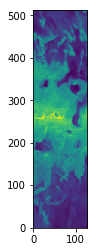

In [31]:
#Let's take a quick look at slice through the density
plt.imshow(den[:,Ny/2,:],norm=LogNorm(),origin='lower')

In [32]:
#You can also extract just a slice of the data

In [33]:
slc=pa.AthenaSlice(ds,axis='y',center='center',field='density')

In [34]:
#Here's some information for the slice
print slc.units
print slc.bound
print slc.axis_labels

0.0345984962637 solMass / pc3
(-512.0, 512.0, -2048.0, 2048.0)
['x', 'z']


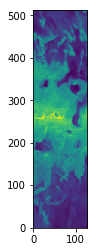

In [35]:
#As expected, this is the same as above
plt.imshow(slc.data,norm=LogNorm(),origin='lower')

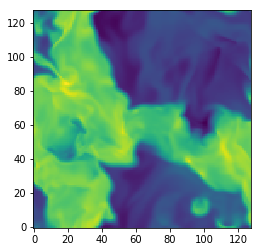

In [36]:
#You can choose the center based on physical coordinates [x,y,z], e.g.:
slc2=pa.AthenaSlice(ds,axis='z',center=[0.,0.,512.],field='density')
plt.imshow(slc2.data,norm=LogNorm(),origin='lower')

In [37]:
#You can find indices of (x,y,z) as follows:
cidx=np.array(pa.cc_idx(ds.domain,[0.,0.,512]),dtype='int')
print cidx

[ 63  63 319]


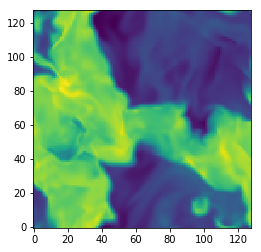

In [38]:
#Note that this the slice selected above is the same as:  
plt.imshow(den[cidx[2],:,:],norm=LogNorm(),origin='lower')
# Note that coordinate indices for the numpy array are in the opposite direction [k,j,i] from (x,y,z)

In [39]:
#This gives the physical size of the domain (x,y,z):
print ds.domain['Lx']

[1024. 1024. 4096.]


In [40]:
#You can create the projection (mean along an axis: z=0,y=1,x=2) of a given variable:
surfd=pa.AthenaSurf(ds,axis=0,field='density')
print surfd.units
#renormalize to represent an integral
surfd.data *=ds.domain['Lx'][2]*surfd.units.value
print surfd.data.min(),surfd.data.max(),surfd.data.mean()

0.0345984962637 solMass / pc3
0.026376504 106.598335 10.09884


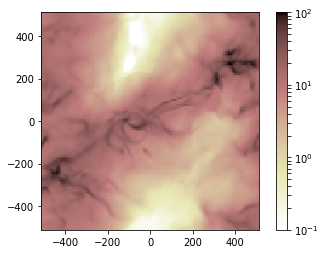

In [41]:
plt.imshow(surfd.data,extent=surfd.bound,cmap='pink_r',norm=LogNorm(),clim=[.1,100])
plt.colorbar()

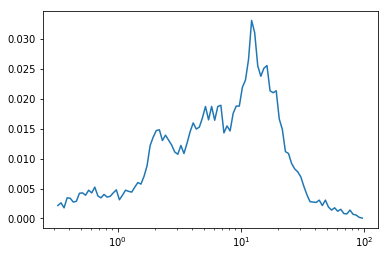

In [42]:
# Let's make a histogram of the log(surface density)
h,edges=np.histogram(np.log10(surfd.data),range=[-.5,2],bins=100)
bins=0.5*(edges[1:]+edges[:-1])
plt.semilogx(10.**bins,h/float(h.sum()))

In [43]:
#This is vertical velocity
slc=pa.AthenaSlice(ds,axis='y',center='center',field='velocity3')

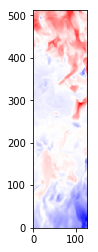

In [44]:
plt.imshow(slc.data,origin='lower',cmap='bwr')

In [45]:
#Let's look at the statistical distribution for the velocity
vx=ds.read_all_data('velocity1')
vz=ds.read_all_data('velocity3')

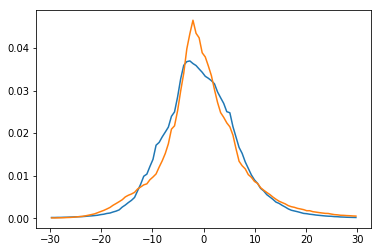

In [46]:
h,edges=np.histogram(vx,weights=den,range=[-30,30],bins=100)
bins=0.5*(edges[1:]+edges[:-1])
plt.plot(bins,h/float(h.sum()))
h,edges=np.histogram(vz,weights=den,range=[-30,30],bins=100)
bins=0.5*(edges[1:]+edges[:-1])
plt.plot(bins,h/float(h.sum()))

(512, 128, 128) (512, 128, 128)


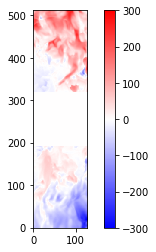

In [47]:
#Let's just select the velocities from high z
Z,Y,X = np.meshgrid(z,y,x, indexing='ij')
tmp=np.zeros(vz.shape)
highz=(abs(Z)>500.)
print highz.shape, Z.shape
tmp[highz]=vz[highz]
plt.imshow(tmp[:,Ny/2,:],origin='lower',cmap='bwr',vmin=-300,vmax=300)
plt.colorbar()

(0.0001, 1)

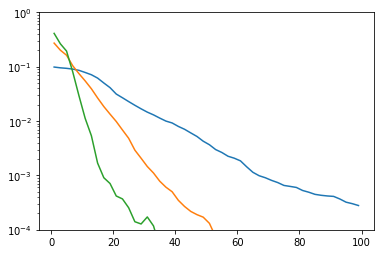

In [48]:
#Let's plot the distributions of |v_z| at high z and low z and near the midplane
#High z:
vh=vz[highz]
wh=den[highz]
h,edges=np.histogram(abs(vh),weights=wh,range=[0,100],bins=50)
bins=0.5*(edges[1:]+edges[:-1])
plt.semilogy(bins,h/float(h.sum()))
#Low z
vl=vz[~highz]
wl=den[~highz]
h2,edges=np.histogram(vl,weights=wl,range=[0,100],bins=50)
plt.semilogy(bins,h2/float(h2.sum()))
#Values within 4 of midplane
h3,edges=np.histogram(vz[Nz/2-4:Nz/2+4,:,:],weights=den[Nz/2-4:Nz/2+4,:,:],range=[0,100],bins=50)
plt.semilogy(bins,h3/float(h3.sum()))
plt.ylim(10**-4,1)

In [49]:
#Now let's look at the temperature
#temp=ds.read_all_data('temperature')
temp=ds.read_all_data('T1')

In [50]:
print temp.min(),temp.max()

1.852892 36887590.0


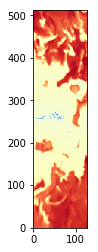

In [51]:
plt.imshow(temp[:,Ny/2,:],norm=LogNorm(),origin='lower',cmap='RdYlBu_r')

In [52]:
#This is P/k =n_H * T
pok=den*temp

In [53]:
#Here's a scatter plot of density vs. P/k
#plt.loglog(den[:,:,:].flatten(),(pok[:,:,:]).flatten(),'.')

In [54]:
#Let's compute the 2D distribution of mass with density and pressure
ld=np.log10(den[:,:,:].flatten())
lp=np.log10(pok[:,:,:].flatten())
rng=[[-2, 2], [1, 5]]
h,xedges,yedges=np.histogram2d(ld,lp,weights=den[:,:,:].flatten(),range=rng,bins=[100,100])
xbins=0.5*(xedges[1:]+xedges[:-1])
ybins=0.5*(yedges[1:]+yedges[:-1])
ht=np.transpose(h)

Text(0,0.5,'log(P/k)')

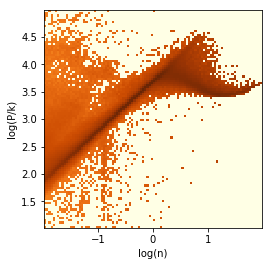

In [55]:
im=plt.imshow(np.log10(ht+1.e-10),origin='lower',cmap='YlOrBr',extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],aspect='equal')
#im.set_extent([xedges.min(),xedges.max(),yedges.min(),yedges.max()])
plt.xlabel('log(n)')
plt.ylabel('log(P/k)')

Reading a history file:/tigress/changgoo/MHD_8pc//id0/MHD_8pc.hst.p


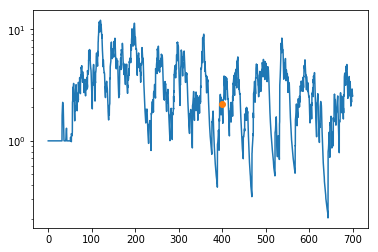

In [56]:
#We would like to compare the data to the predicted equilibrium pressure vs. density
#First need to find heating ratio from history file
hst=pa.hst_reader('%s/id0/%s.hst' % (ds.dir,ds.id))
hratio=np.interp(ds.domain['time'],hst.time,hst.heat_ratio)
plt.plot(hst.time,hst.heat_ratio)
plt.plot(ds.domain['time'],np.interp(ds.domain['time'],hst.time,hst.heat_ratio),'o')
plt.yscale('log')

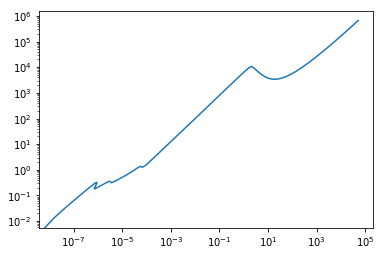

In [60]:
#This gets information about the cooling function 
coolftn=pa.coolftn()
nden=coolftn.heat*hratio/coolftn.cool
peq=coolftn.temp*nden
plt.loglog(nden,peq)

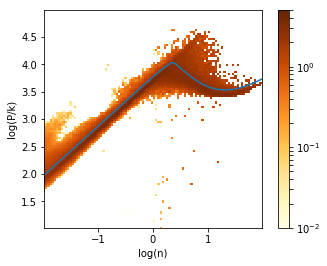

In [61]:
#Now put the data together with the equilibrium prediction
im=plt.imshow(np.log10(ht+1.e-8),origin='lower',cmap='YlOrBr',aspect='equal',norm=LogNorm(),clim=[.01,5])
plt.colorbar()
im.set_extent([xedges.min(),xedges.max(),yedges.min(),yedges.max()])
plt.xlabel('log(n)')
plt.ylabel('log(P/k)')
#Add equilibrium pressure vs density curve
plt.ylim(ybins.min(),ybins.max())
plt.xlim(xbins.min(),xbins.max())
plt.plot(np.log10(nden*1.1+1.e-10),np.log10(peq+1.e-10))
#plt.axes().set_aspect('equal')